In [ ]:
# pip install for all relevant modules
pip install gdown
pip install zipfile
pip install numpy
pip install os
pip install PIL
pip install skimage
pip install cv2
pip install math
pip install tqdm
pip install tensorflow
pip install matplotlib

In [ ]:
# To connect your drive for storing the data later on (can also be downloaded from colab without storing in drive)
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Option for downloading the file from a URL
import gdown
import zipfile

# Cohort level data
url_cohort = 'https://drive.google.com/uc?id=1XLVOQ5wF-7LRjxYa5vDfWN6uZN23s4WT'
# multiple URLs in case one isn't working:
# https://drive.google.com/uc?id=1XLVOQ5wF-7LRjxYa5vDfWN6uZN23s4WT
# https://drive.google.com/uc?id=1-ATi4l8m4BmRWV9eYKrg_ojQ_j1DLW7-

output_cohort = '/content/cohort.zip' #change the path of where the zip file is stored
gdown.download(url_cohort, output_cohort, quiet=False)

with zipfile.ZipFile('/content/cohort.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data') # change the path of where the zip file is opened to

Downloading...
From: https://drive.google.com/uc?id=1rijo6N5RDr4bas7doog8-s8n3nYyutkb
To: /content/cohort.zip
100%|██████████| 8.03G/8.03G [02:35<00:00, 51.6MB/s]


In [ ]:
# If you have stored the dataset locally change the paths accordingly
with zipfile.ZipFile('/content/cohort.zip', 'r') as zip_ref:  # change the path where the zip file is stored
    zip_ref.extractall('/content/data') # change the path of where the zip file is opened to

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
from skimage import exposure
from skimage.color import rgb2gray
import cv2
import math
from tqdm import tqdm

In [ ]:
def preprocessing_function(edge_enhance, equalization, blur, image):

    # apply gaussian blur to the image
    image = cv2.GaussianBlur(image, (blur, blur), 0 )
    # edge enhance using PIL
    if edge_enhance:
        image = Image.fromarray(image)
        image = image.filter(ImageFilter.EDGE_ENHANCE)
        image = np.array(image)
    else:
        image = image
    
    # equalization
    if equalization == 'histogram':
        image = cv2.equalizeHist(image)
    elif equalization == 'adaptive':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
    else: 
        image = image
    
    # Flip
    image = image
    image1 = cv2.flip(image, 1)

    return image, image1

In [ ]:
def crop_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold 
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    hh, ww = thresh.shape

    # make bottom 2 rows black where they are white the full width of the image
    thresh[hh-3:hh, 0:ww] = 0

    # get bounds of white pixels
    white = np.where(thresh==255)
    xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])
    hd = ymax-ymin
    wd = xmax-xmin
    g = 0 
    j = 0
    m = 0
    f = 0
    # Keep the aspect ratio the same
    if hd > wd and (ymin <2 or ymax + 2 > img.shape[0]):
        g = 0
        j = 0
        t = (hd-wd) / 2 
        if xmin - math.floor(t) >= 0 and xmax + math.ceil(t) <= img.shape[1]:
            m = math.floor(t)
            f = math.ceil(t)
        elif xmin - math.floor(t) >= 0:
            f = img.shape[1]-xmax
            m = ((2*t)-f)
        else:
            m = xmin
            f = ((2*t)-m)
    elif hd > wd and (ymin >= 2 or ymax + 2 <= img.shape[0]):
        g = 2
        j = 2
        t = ((hd+4)-wd) / 2
        if xmin - math.floor(t) >= 0 and xmax + math.ceil(t) <= img.shape[1]:
            m = math.floor(t)
            f = math.ceil(t)
        elif xmin - math.floor(t) >= 0:
            f = img.shape[1]-xmax
            m = ((2*t)-f)
        else:
            m = xmin
            f = ((2*t)-m)
    elif wd > hd and (xmin < 2 or xmax +2 > img.shape[1]):
        m = 0 
        f = 0
        t = (wd-hd) / 2 
        if ymin - math.floor(t) >= 0 and ymax + math.ceil(t) <= img.shape[0]:
            g = math.floor(t)
            j = math.ceil(t)
        elif ymin - math.floor(t) >= 0:
            j = img.shape[0]-ymax
            g = ((2*t)-j)
        else:
            g = ymin
            j = ((2*t)-g)
    elif wd > hd and (xmin >= 2 or xmax + 2 <= img.shape[1]):
        m = 2 
        f = 2
        t = ((wd+4)-hd) / 2 
        if ymin - math.floor(t) >= 0 and ymax + math.ceil(t) <= img.shape[0]:
            g = math.floor(t)
            j = math.ceil(t)
        elif ymin - math.floor(t) >= 0:
            j = img.shape[0]-ymax
            g = ((2*t)-j)
        else:
            g = ymin
            j = ((2*t)-g)
    elif wd == hd:
      if wd + 4 <= img.shape[1] and hd + 4 <= img.shape[0]:
        g = 2 
        j = 2
        m = 2
        f = 2
      else: 
        g = 0 
        j = 0
        m = 0
        f = 0
    
    # crop the image at the bounds
    if hd + 4 > img.shape[1] or wd + 4 > img.shape[0]:
        crop = img[:,:,0]
    elif hd == 0 or wd == 0:
        crop = img[:,:,0]
    else:
        xx = int(ymin-g)
        xy = int(ymax+j)
        yx = int(xmin-m)
        yy = int(xmax+f)
        crop = img[xx:xy, yx:yy,0]
    if crop.shape[0] != crop.shape[1]:
      crop = img[:,:,0]
    return crop

In [ ]:
# Removing the folder directory for the next preprocessing test (only run after having completed the model and saved the metrics)
!rm -rf '/content/data/aug'

In [ ]:
# Creating the directory for storing the preprocessed Data (change the paths when running locally)
os.mkdir('/content/data/aug/')
i = 15
while i < 90:
  j = 0
  while j < 2:
    os.mkdir('/content/data/aug/'+ str(i) + "-" + str(j))
    j += 1
  i += 5

In [ ]:
# The paths need to be adapted if run locally
data_dir = '/content/data/cohorts_5/' # path to the original dataset
target_path = '/content/data/aug/'    # path to where the preprocessed dataset will be stored
# equalization: histogram or adaptive
preprocessing_args = {
    'edge_enhance': False,
    'equalization': 'histogram',
    'blur': 3
}
errors = []   # stores any errors that occur (used in testing)
shape = []    # stores the shape of the final images to ensure that they have the same aspect ratio
for folder in os.listdir(data_dir):
    # add folder to the data_dir path
    folder_path = data_dir + folder + '/'
    for image in os.listdir(folder_path):
        try:
            img = cv2.imread(folder_path + image, cv2.COLOR_BGR2GRAY)
            # cropping 
            print(folder_path + image)
            img = crop_image(img)
            # check that the image has no 0 in its shape, if so. reload it
            if 0 in img.shape:
                img = cv2.imread(folder_path + image, cv2.COLOR_BGR2GRAY)
                img = img[:,:,0]

            temp, temp1 = preprocessing_function(preprocessing_args['edge_enhance'],  
                                          preprocessing_args['equalization'],
                                          preprocessing_args['blur'],
                                          img)

            # add a _i to the image name
            path = target_path + folder + '/' + image[:-4] + '_0.png'
            cv2.imwrite(path, temp)
            path1 = target_path + folder + '/' + image[:-4] + '_1.png'
            cv2.imwrite(path1, temp1)
            shape.append([temp.shape,temp1.shape])
        except Exception as e:
            errors.append([e, folder_path + image])
            print("error")
            pass

Streaming output truncated to the last 5000 lines.
/content/data/cohorts_5/30-0/005547.png
/content/data/cohorts_5/30-0/001948.png
/content/data/cohorts_5/30-0/006454.png
/content/data/cohorts_5/30-0/007762.png
/content/data/cohorts_5/30-0/009369.png
/content/data/cohorts_5/30-0/007911.png
/content/data/cohorts_5/30-0/009886.png
/content/data/cohorts_5/30-0/001318.png
/content/data/cohorts_5/30-0/008171.png
/content/data/cohorts_5/30-0/001787.png
/content/data/cohorts_5/30-0/009312.png
/content/data/cohorts_5/30-0/008810.png
/content/data/cohorts_5/30-0/008704.png
/content/data/cohorts_5/30-0/000082.png
/content/data/cohorts_5/30-0/000819.png
/content/data/cohorts_5/30-0/001788.png
/content/data/cohorts_5/30-0/009112.png
/content/data/cohorts_5/30-0/008050.png
/content/data/cohorts_5/30-0/006660.png
/content/data/cohorts_5/30-0/002578.png
/content/data/cohorts_5/30-0/004667.png
/content/data/cohorts_5/30-0/004394.png
/content/data/cohorts_5/30-0/002959.png
/content/data/cohorts_5/30-0/

In [ ]:
shape2 = pd.DataFrame(shape, columns=['shape 1','shape 2'])
shape2.to_csv('shape.csv', index=False)

In [ ]:
errors = pd.DataFrame(errors, columns=['error', 'path'])
errors.to_csv('errors.csv', index=False)

In [ ]:
# create a zip file of the preprocessed data
!zip -r /content/drive/MyDrive/Preprocessed.zip /content/data/aug/ #change the first path if you have not connected your drive

# Preprocessing Testing

This is the code that was used to test the different preprocessing processes.

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [ ]:
size = 224
input_dim = (size, size, 1)
classes = 30
batch_size = 16
epochs = 32
data_dir = '/content/data/aug/'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  subset='training',
  validation_split=0.2,
  labels = 'inferred',
  label_mode='categorical',
  seed=42,
  image_size=(size, size),
  batch_size=batch_size,
  color_mode='grayscale')

Found 10700 files belonging to 30 classes.
Using 8560 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  subset='validation',
  validation_split=0.2,
  labels = 'inferred',
  label_mode='categorical',
  seed=42,
  image_size=(size, size),
  batch_size=batch_size, 
  color_mode='grayscale')

Found 10657 files belonging to 30 classes.
Using 2131 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['15-0', '15-1', '20-0', '20-1', '25-0', '25-1', '30-0', '30-1', '35-0', '35-1', '40-0', '40-1', '45-0', '45-1', '50-0', '50-1', '55-0', '55-1', '60-0', '60-1', '65-0', '65-1', '70-0', '70-1', '75-0', '75-1', '80-0', '80-1', '85-0', '85-1']


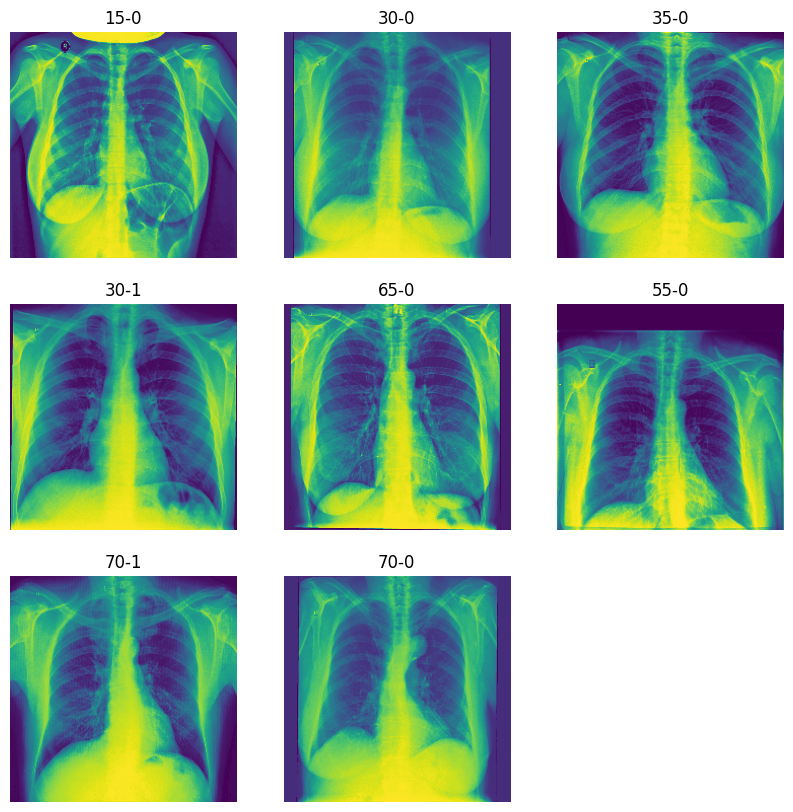

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [ ]:
#function to delete the model after each run through
def delete_model(model):
  del model
  tf.keras.backend.clear_session()

In [ ]:
# After each run to delete the model to continue in the same instance
delete_model(model)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, BatchNormalization, MaxPooling2D, Dense
from tensorflow.keras.models import Model


input = Input(shape=input_dim)

conv1 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(input)
conv1 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(conv1)
conv1 = Dropout(0.1)(conv1)
mpool1 = MaxPooling2D()(conv1)

conv2 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(mpool1)
conv2 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(conv2)
conv2 = Dropout(0.2)(conv2)
mpool2 = MaxPooling2D()(conv2)

conv3 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(mpool2)
conv3 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(conv3)
conv3 = Dropout(0.3)(conv3)
mpool3 = MaxPooling2D()(conv3)

conv4 = Conv2D(512, 3, activation='relu', padding='same')(mpool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
conv4 = Dropout(0.4)(conv4)
mpool4 = MaxPooling2D()(conv4)
# get the output of the base model

# Net 1 for age
net_1_conv1 = Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'same')(mpool4)
net_1_conv2 = Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'same')(net_1_conv1)
net_1_drop1 = Dropout(0.2)(net_1_conv2)
net_1_pool1 = MaxPooling2D(pool_size = (3, 3), padding = 'same')(net_1_drop1)

net_1_conv3 = Conv2D(512, kernel_size=(3, 3), strides=(1,1), activation='relu', padding = 'same')(net_1_pool1)
net_1_drop2 = Dropout(rate=0.2)(net_1_conv3)

net_1_conv4 = Conv2D(1024, kernel_size=(3, 3), strides=(1,1), activation='relu')(net_1_drop2)
net_1_drop3 = Dropout(rate=0.4)(net_1_conv4)

net_1_conv5 = Conv2D(1024, kernel_size=(3, 3), strides=(1,1), activation='relu')(net_1_drop3)
net_1_drop4 = Dropout(rate=0.2)(net_1_conv5)

# Inference layer
net_1_batch = BatchNormalization()(net_1_drop4)
flatten1 = Flatten()(net_1_batch)
out1 = Dense(classes, activation='softmax', name='age')(flatten1)

model = Model(inputs=input, outputs=out1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 dropout (Dropout)           (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                             

In [ ]:
callbacks = [ModelCheckpoint('cohorts.hdf5', verbose=1, save_best_only=True, save_weights_only=True,
                             monitor = 'val_loss'),
             EarlyStopping(monitor = 'val_loss', patience = 16, restore_best_weights = True)]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
history = model.fit(train_ds,  validation_data=val_ds,
            epochs=epochs, 
            shuffle=True,
            callbacks=callbacks)

Epoch 1/32
533/533 [==============================] - ETA: 0s - loss: 3.4455 - accuracy: 0.0732 - precision: 0.0800 - recall: 7.0373e-04 - auc: 0.6372
Epoch 1: val_loss improved from inf to 3.60987, saving model to cohorts.hdf5
533/533 [==============================] - 186s 305ms/step - loss: 3.4455 - accuracy: 0.0732 - precision: 0.0800 - recall: 7.0373e-04 - auc: 0.6372 - val_loss: 3.6099 - val_accuracy: 0.0643 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5877
Epoch 2/32
533/533 [==============================] - ETA: 0s - loss: 2.9543 - accuracy: 0.1221 - precision: 0.1443 - recall: 0.0016 - auc: 0.7766
Epoch 2: val_loss improved from 3.60987 to 3.26686, saving model to cohorts.hdf5
533/533 [==============================] - 141s 264ms/step - loss: 2.9543 - accuracy: 0.1221 - precision: 0.1443 - recall: 0.0016 - auc: 0.7766 - val_loss: 3.2669 - val_accuracy: 0.0863 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6932
Epoch 3/32
533/533 [======

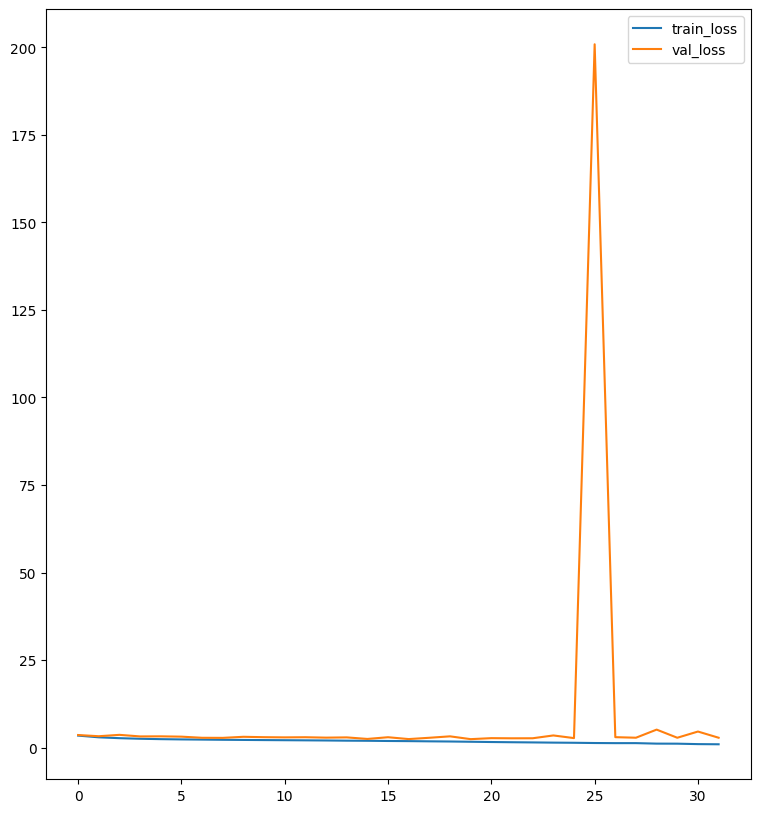

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# load the best model
model.load_weights('cohorts.hdf5')

# get the predictions
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

# get the true labels
y_true = []
for images, labels in val_ds:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true)
y_true = np.argmax(y_true, axis=1)

# get the classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report = pd.DataFrame(report).transpose()
# add the historty to the report
output = [report, history.history['loss'], history.history['val_loss']]

# conert the output to a dataframe
output = pd.DataFrame(output)
# name the columns
output.index = ['classification_report', 'train_loss', 'val_loss']
output.to_csv('output.csv')

134/134 [==============================] - 7s 52ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/co

In [ ]:
# Download the files automatically in colab
from google.colab import files
files.download('output.csv')
files.download('errors.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os.path
output.to_csv(os.path.join('myfolder','output.csv'))
errors.to_csv(os.path.join('myfolder','errors.csv'))